In [153]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import rcParams, pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow_probability import sts

rcParams['figure.figsize'] = [12, 8]
rcParams['figure.dpi'] = 200

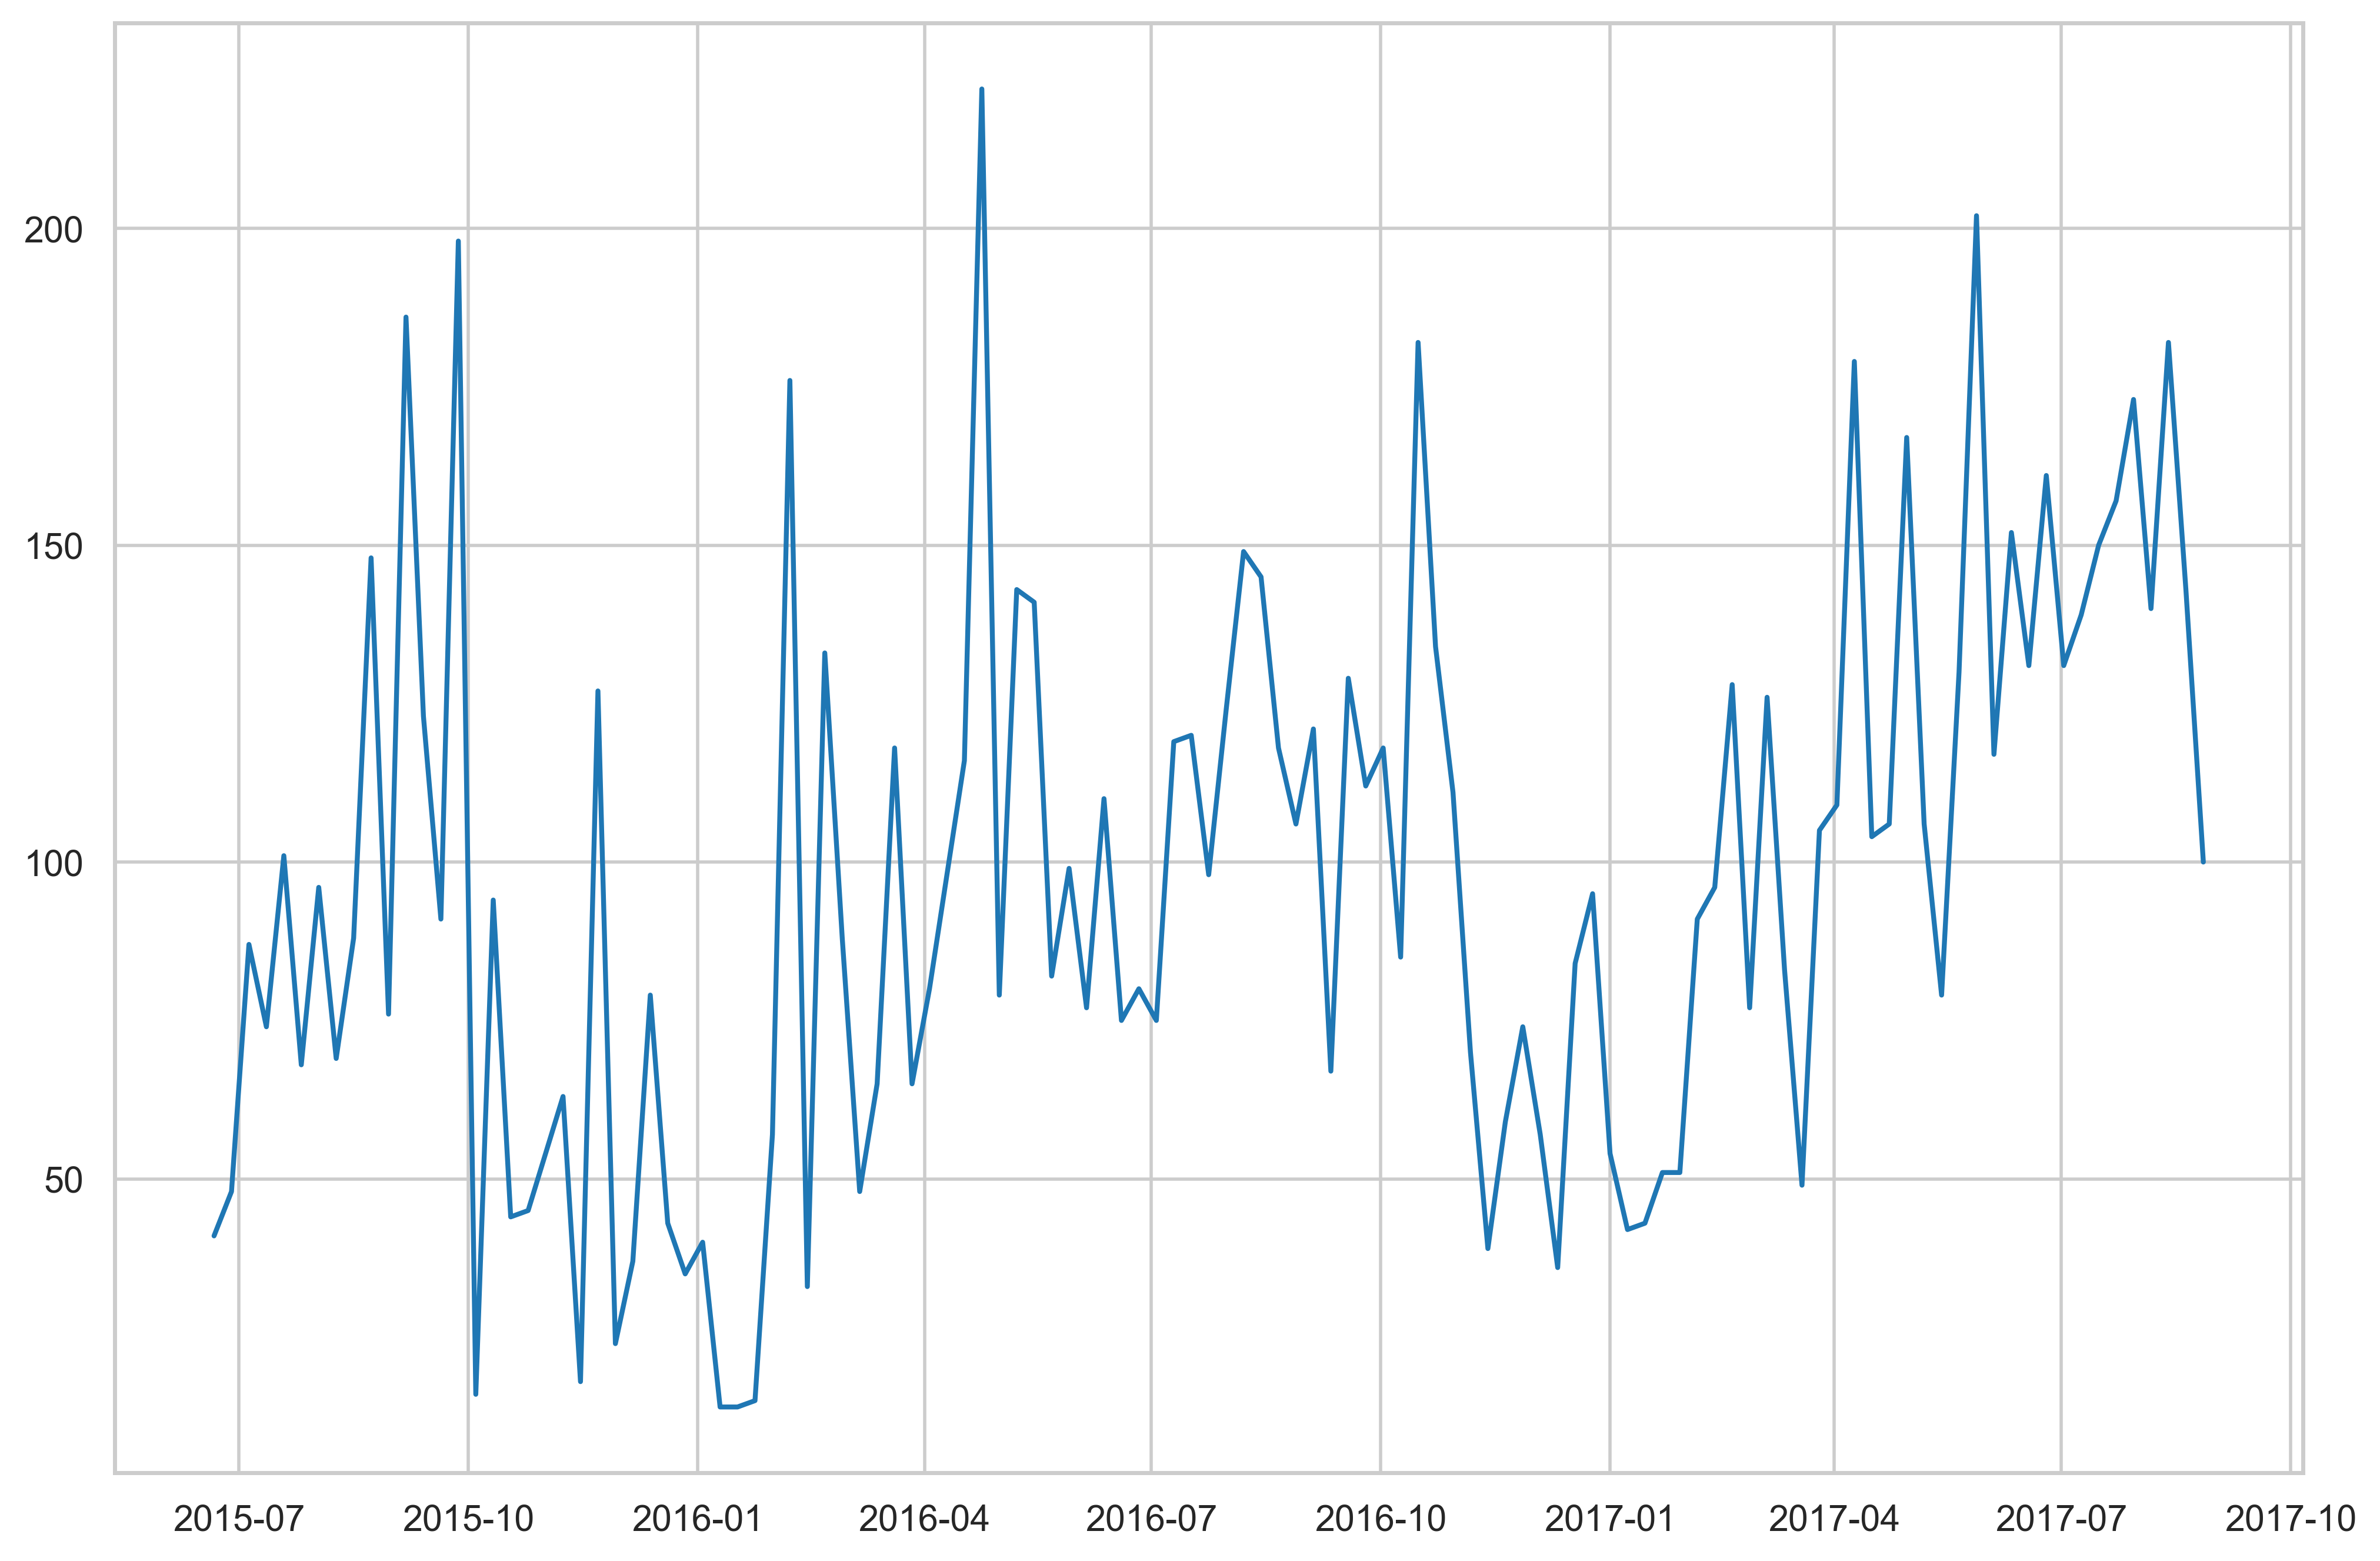

In [154]:
df = pd.read_csv('data/h1weekly.csv',
                 parse_dates=['Date'],
                 index_col='Date',
                 dtype={'IsCanceled': float})
df.index.freq = 'W-SUN'
_ = plt.plot(df)

In [155]:
train_data, test_data = train_test_split(df, test_size=0.1, shuffle=False)
train_data_tensor = tf.convert_to_tensor(train_data['IsCanceled'].to_numpy(), dtype=tf.float64)

In [156]:
def build_model(observed_time_series: pd.Series, num_seasons: int) -> sts.Sum:
    trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
    seasonal = sts.Seasonal(num_seasons=num_seasons, observed_time_series=observed_time_series)
    return sts.Sum([trend, seasonal], observed_time_series=observed_time_series)

In [157]:
with tf.device('CPU:0'):
    model = build_model(train_data_tensor, 52)
    variational_posteriors = sts.build_factored_surrogate_posterior(model=model)

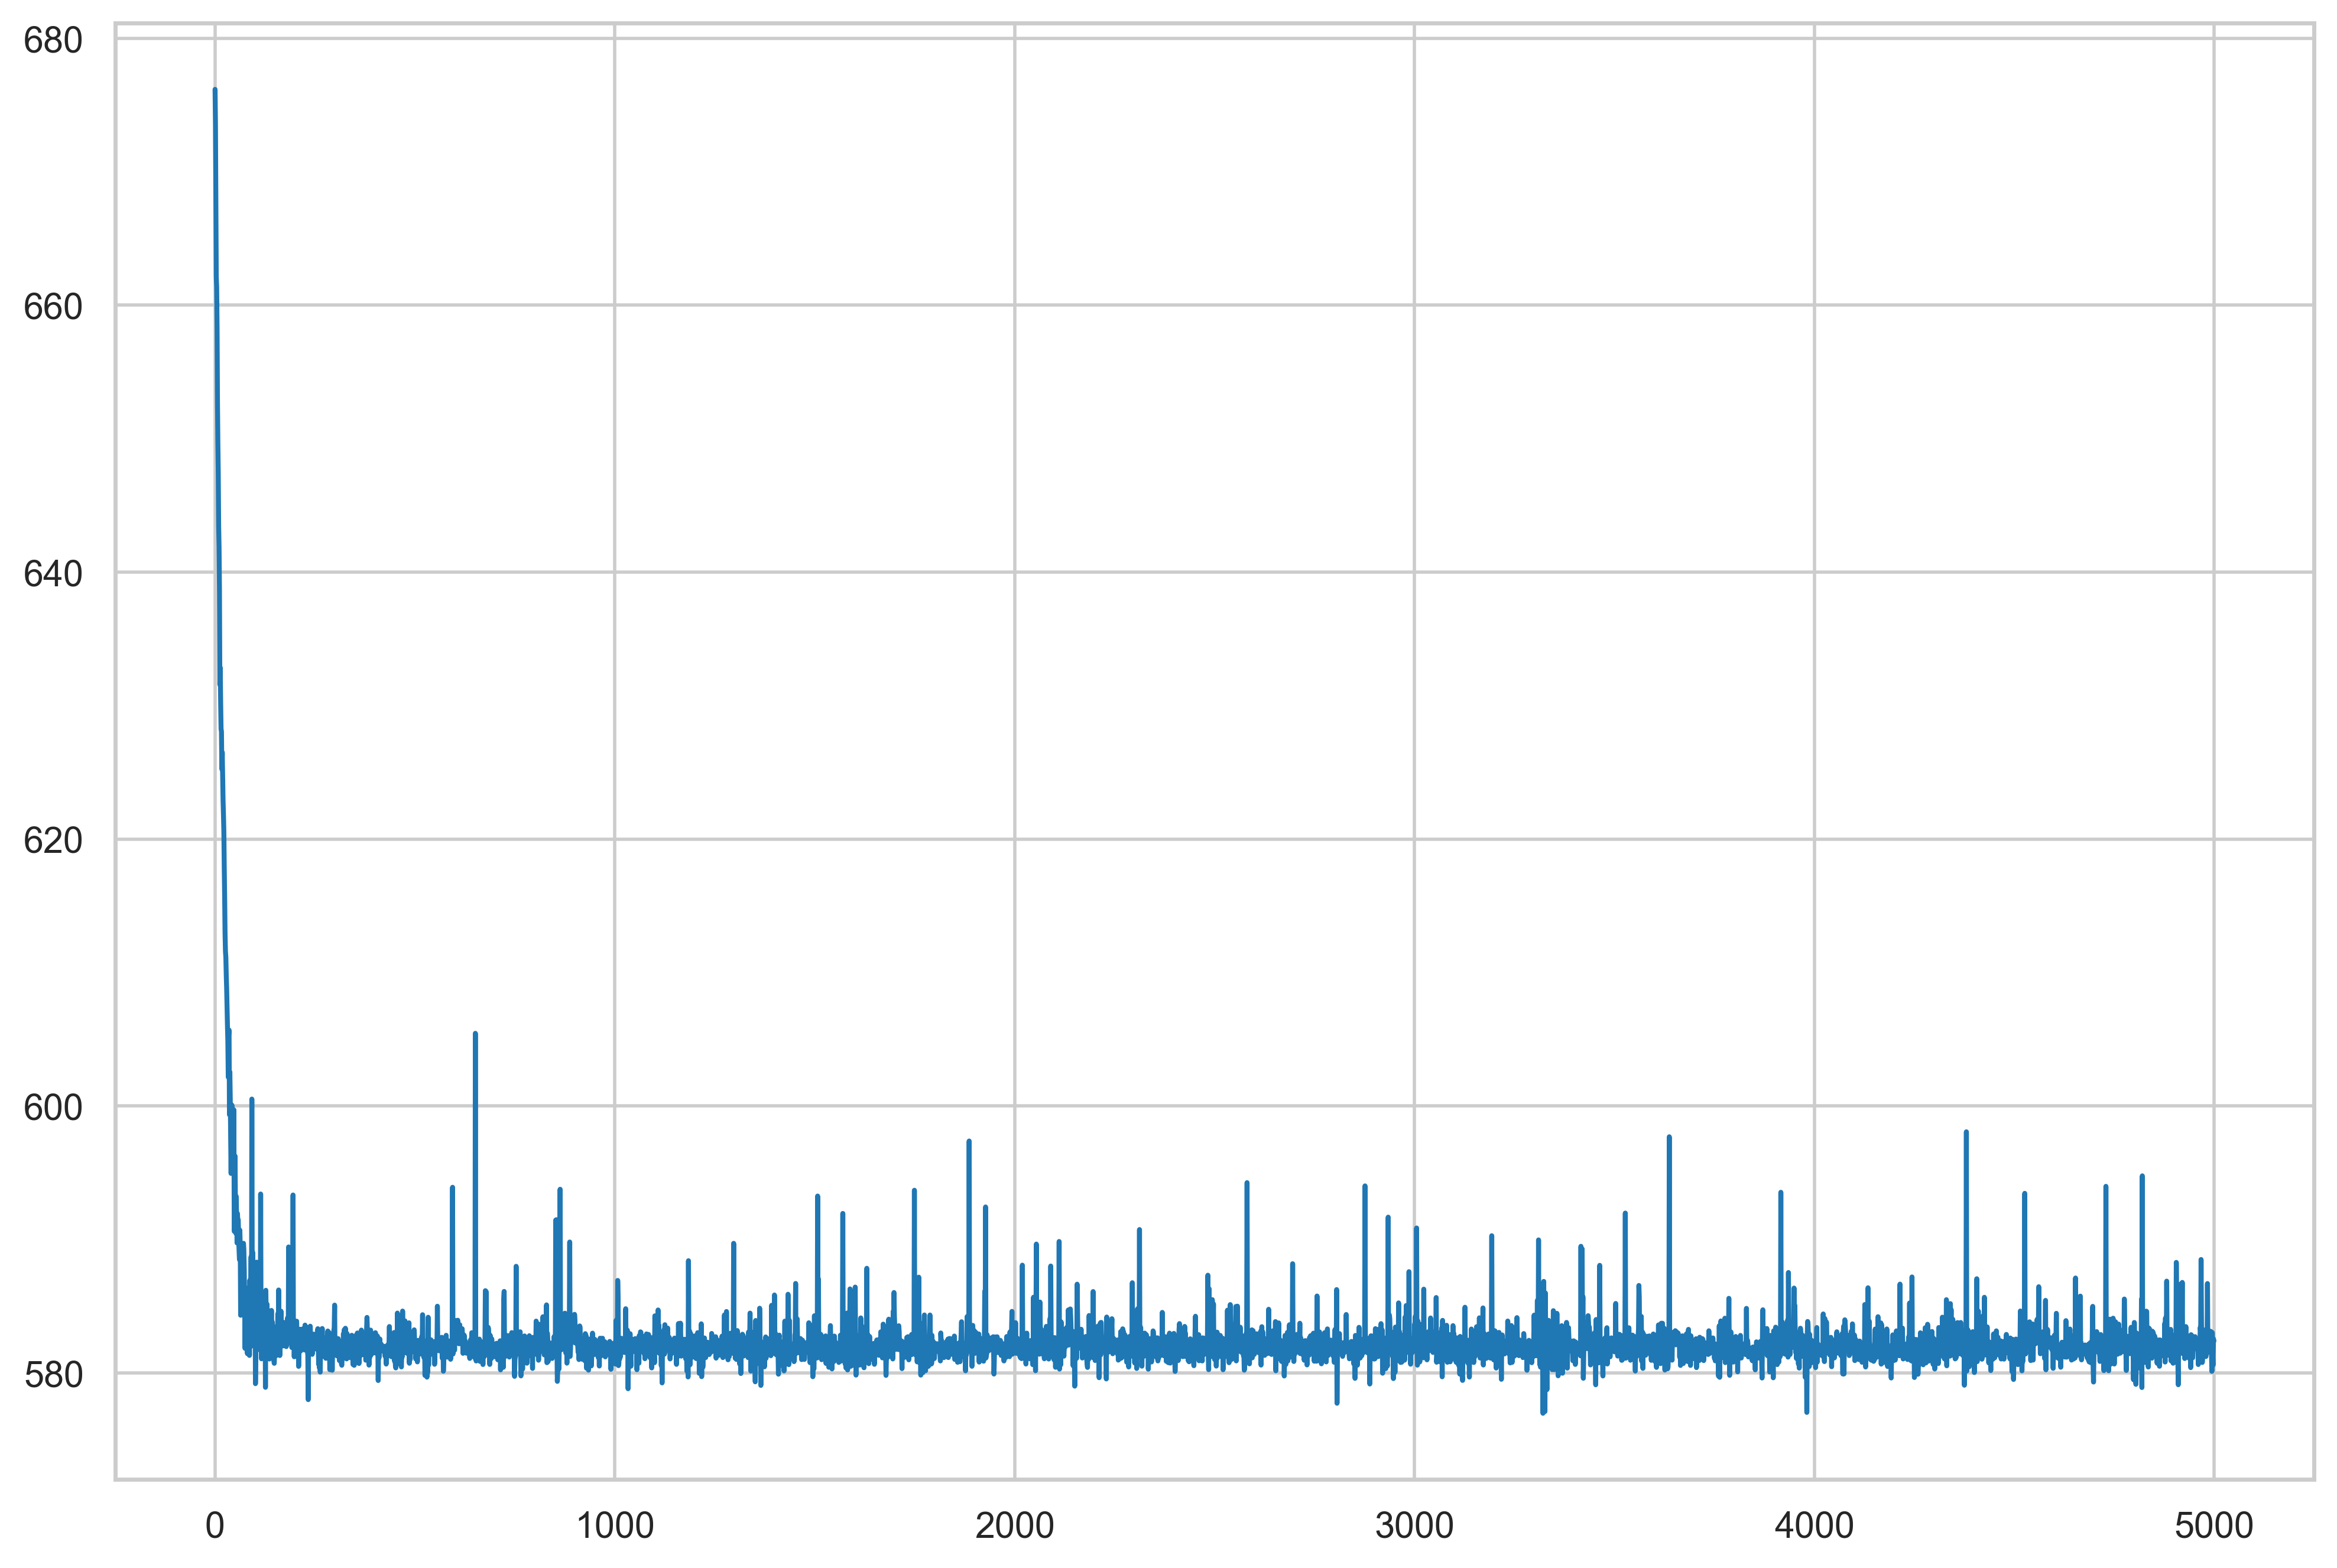

In [158]:
# Minimize the variational loss.

# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 5000
num_variational_steps = int(num_variational_steps)

# Build and optimize the variational loss function.
with tf.device('CPU:0'):
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=model.joint_distribution(observed_time_series=train_data_tensor).log_prob,
        surrogate_posterior=variational_posteriors,
        optimizer=tf.optimizers.legacy.Adam(learning_rate=0.1),
        num_steps=num_variational_steps,
        jit_compile=False
    )

plt.plot(elbo_loss_curve)
plt.show()

# Draw samples from the variational posterior.
parameter_samples = variational_posteriors.sample(1000)

In [159]:
print("Inferred parameters:")
for param in model.parameters:
    print("{}: {} +- {}".format(param.name,
                                np.mean(parameter_samples[param.name], axis=0),
                                np.std(parameter_samples[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 1.0266211595029178 +- 2.32356783358705
LocalLinearTrend/_level_scale: 0.35605893615023 +- 0.5839216001331586
LocalLinearTrend/_slope_scale: 0.062158795864484154 +- 0.07034750783153597
Seasonal/_drift_scale: 54.91746170576439 +- 5.009610574413855


In [160]:
forecast_dist = tfp.sts.forecast(model,
                                 observed_time_series=train_data_tensor,
                                 parameter_samples=parameter_samples,
                                 num_steps_forecast=len(test_data))

In [161]:
num_samples=100

forecast_mean, forecast_scale, forecast_samples = (
    forecast_dist.mean().numpy()[..., 0],
    forecast_dist.stddev().numpy()[..., 0],
    forecast_dist.sample(num_samples).numpy()[..., 0],
)

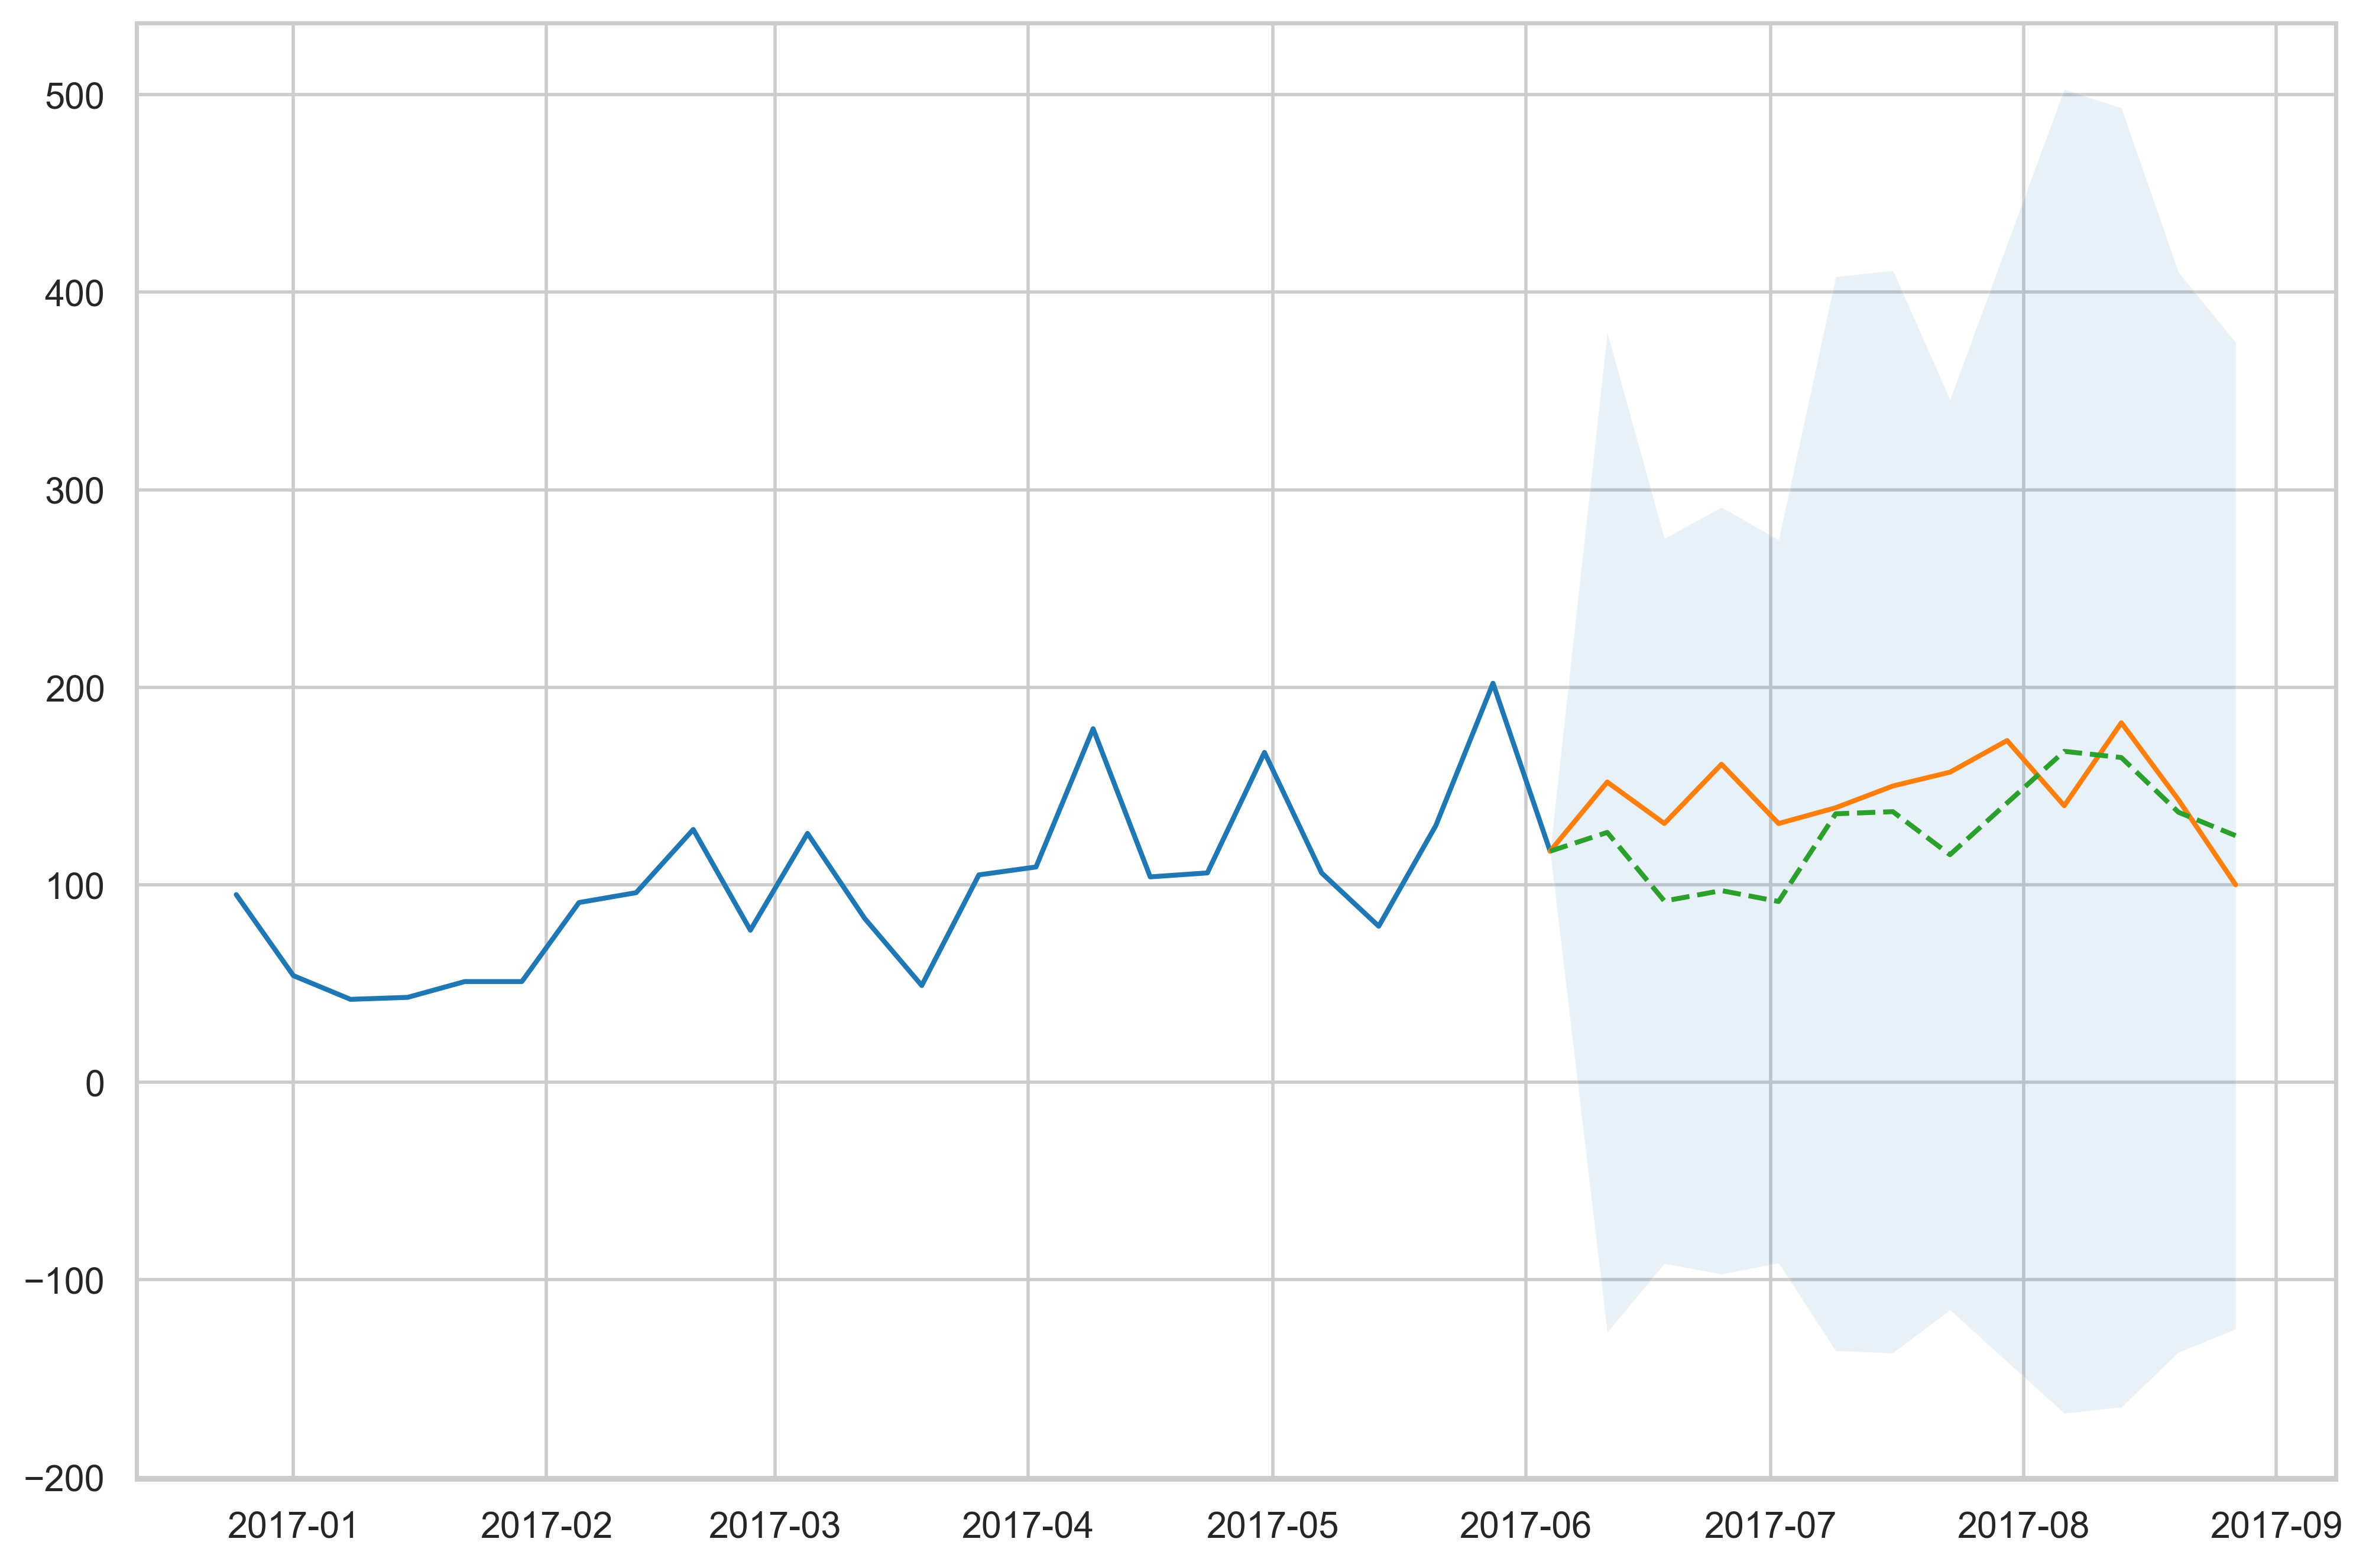

In [162]:
train_data_plot = train_data[-24:]
test_data_plot = pd.concat([train_data.iloc[-1:], test_data])
last_observation = train_data['IsCanceled'].iloc[-1]
forecast_mean_plot = np.concatenate(([last_observation], forecast_mean))
forecast_scale_plot = np.concatenate(([0], forecast_mean))

plt.plot(train_data_plot.index, train_data_plot['IsCanceled'], label='Training Data')
plt.plot(test_data_plot.index, test_data_plot['IsCanceled'], label='Test Data')

plt.plot(test_data_plot.index, forecast_mean_plot, label='Forecast', linestyle='--')
_ = plt.fill_between(test_data_plot.index,
                     forecast_mean_plot - 2 * forecast_scale_plot,
                     forecast_mean_plot + 2 * forecast_scale_plot,
                     alpha=0.1)

In [163]:
component_dists = sts.decompose_by_component(model,
                                             observed_time_series=train_data_tensor,
                                             parameter_samples=parameter_samples)
component_means_, component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()}
)

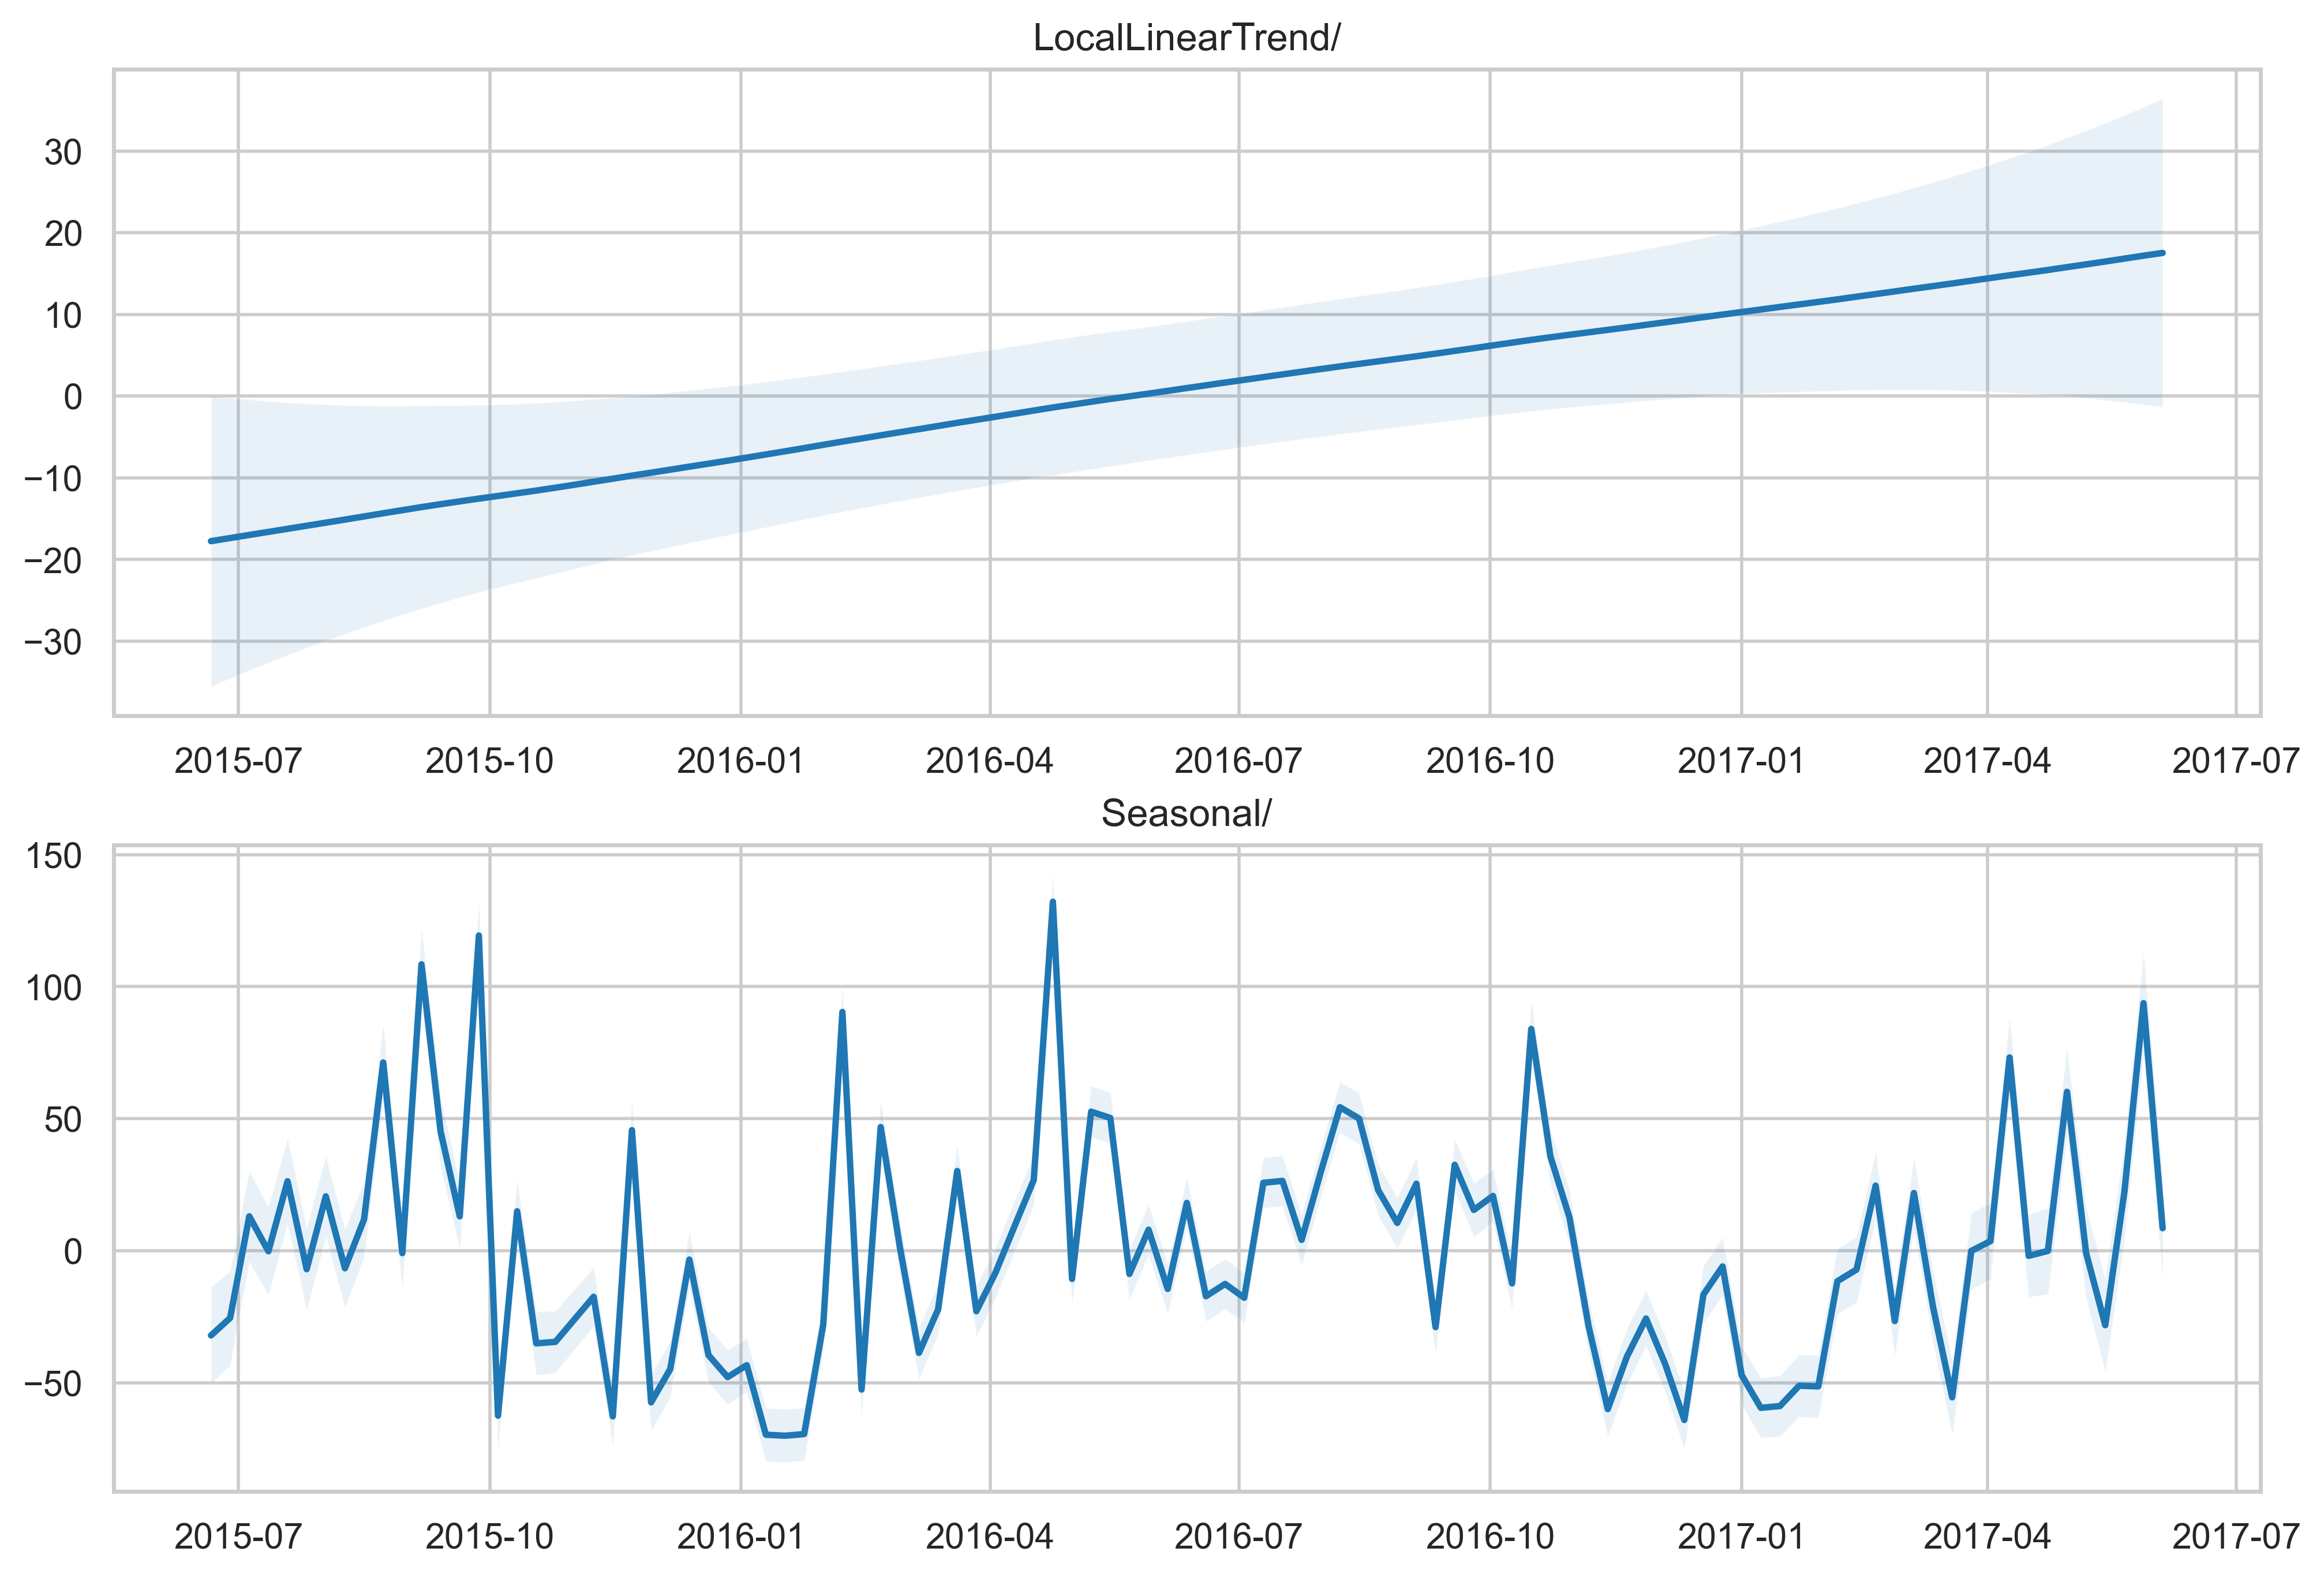

In [164]:
num_components = len(component_means_)

fig = plt.figure()
for i, component_name in enumerate(component_means_.keys()):
    component_mean   = component_means_[component_name]
    component_stddev = component_stddevs_[component_name]

    ax = fig.add_subplot(num_components,1,1+i)
    ax.plot(train_data.index, component_mean, lw=2)
    ax.fill_between(train_data.index,
                    component_mean - 2 * component_stddev,
                    component_mean + 2 * component_stddev,
                    alpha=0.1)
    ax.set_title(component_name)